In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [30]:
# 1. CHARGEMENT des données
df = pd.read_csv('train.csv')
df['HasCrCard'] = df['HasCrCard'].astype(int)
df['IsActiveMember'] = df['IsActiveMember'].astype(int)
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0


In [31]:
# Suppression des colonnes non-prédictives pour le modèle
df_net = df.drop(['id', 'CustomerId', 'Surname'], axis=1)


In [32]:
# Encodage  pour Geography et Gender(One-Hot Encoding)
df_encoded = pd.get_dummies(df_net, columns=['Geography', 'Gender'], drop_first=True)
df_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,668,33.0,3,0.00,2,1,0,181449.97,0,False,False,True
1,627,33.0,1,0.00,2,1,1,49503.50,0,False,False,True
2,678,40.0,10,0.00,2,1,0,184866.69,0,False,False,True
3,581,34.0,2,148882.54,1,1,1,84560.88,0,False,False,True
4,716,33.0,5,0.00,2,1,1,15068.83,0,False,True,True


In [33]:
# 2. PRÉPARATION ET SPLIT STRATIFIÉ

X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

# Stratification pour respecter le ratio 78%/22% de churn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# 3. réglage des hyperparamètres (TUNING) (RANDOM SEARCH + CV STRATIFIÉ)

stratKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# class_weight='balanced' aide le modèle à mieux voir la classe minoritaire  qui est les départs

rf = RandomForestClassifier(random_state=42, oob_score=True, class_weight='balanced')

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param,
    n_iter=10,
    cv=stratKFold,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("--- RÉSULTATS DU TUNING ---")
print(f"Meilleure combinaison : {random_search.best_params_}")
print(f"Meilleur score F1 (moyenne CV) : {random_search.best_score_:.4f}")

--- RÉSULTATS DU TUNING ---
Meilleure combinaison : {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Meilleur score F1 (moyenne CV) : 0.6576


In [28]:
# 4. ANALYSE DES PROBABILITÉS ET SEGMENTATION 

# Récupération des probabilités pour le dataset
y_probs = best_model.predict_proba(X_test)[:, 1]

# Fonction de segmentation du risque
def segmenter_risque(proba):
    if proba >= 0.8: return '1. Critique'
    elif proba >= 0.5: return '2. Élevé'
    elif proba >= 0.2: return '3. Modéré'
    else: return '4. Faible'
        

In [29]:
# Création d'un DataFrame de résultats
resultats_finaux = pd.DataFrame({'Réalité': y_test, 'Probabilité_Churn': y_probs})
resultats_finaux['Niveau_Risque'] = resultats_finaux['Probabilité_Churn'].apply(segmenter_risque)


In [14]:
# 5. AFFICHAGE DES RÉSULTATS POUR LE RAPPORT

print(f"\nMeilleurs paramètres : {random_search.best_params_}")
print(f"Score OOB : {best_model.oob_score_:.4f}")

print("\n--- RAPPORT DE PERFORMANCE ---")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))




Meilleurs paramètres : {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Score OOB : 0.8469

--- RAPPORT DE PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     26023
           1       0.63      0.69      0.66      6984

    accuracy                           0.85     33007
   macro avg       0.77      0.79      0.78     33007
weighted avg       0.85      0.85      0.85     33007



### Ce tableau détaille la qualité des prédictions pour chaque classe (0 et 1) :

Classe 0 (Majoritaire - 26 023 exemples) :

Précision (0.91) : Quand il prédit "0", il a raison 91% du temps.

Recall (0.89) : Il arrive à capturer 89% des vrais "0".

F1-score (0.90) : Un excellent équilibre pour cette classe.

Classe 1 (Minoritaire - 6 984 exemples) :

Précision (0.63) : C'est le point faible. 37% de ses prédictions "1" sont en fait des erreurs.

Recall (0.69) : Il détecte 69% des cas réels de type "1".

F1-score (0.66) : C'est la moyenne harmonique des deux, montrant que le modèle est "correct" mais pas exceptionnel sur cette classe.

Le score OOB (Out-of-Bag) est une méthode d'évaluation propre au Random Forest. 
Comme chaque arbre est entraîné sur seulement une partie des données (via le bagging), le modèle teste chaque arbre sur les données qu'il n'a jamais vues.
C'est une sorte de validation croisée intégrée : elle permet d'estimer la performance du modèle sur de nouvelles données sans avoir besoin d'un jeu de test séparé..
le score OOB est le score d'auto-évaluation du modèle.


C:\Users\hp\AppData\Local\Temp\ipykernel_31352\1868209114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultats_finaux.sort_values('Niveau_Risque'), x='Niveau_Risque', palette='magma')


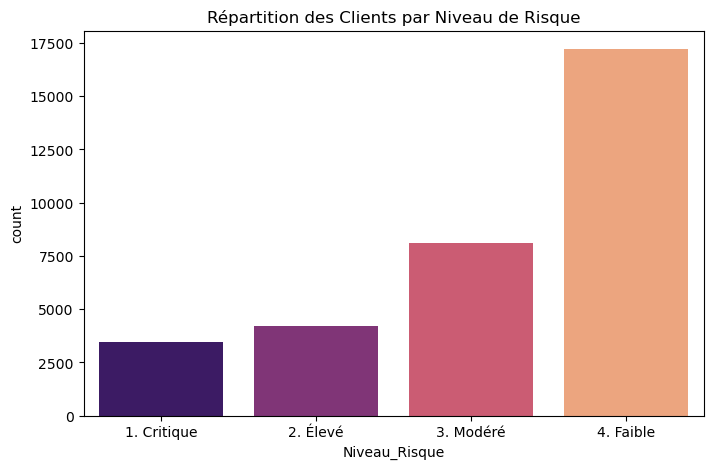

In [15]:
# Visualisation 1 : Distribution des Risques
plt.figure(figsize=(8, 5))
sns.countplot(data=resultats_finaux.sort_values('Niveau_Risque'), x='Niveau_Risque', palette='magma')
plt.title("Répartition des Clients par Niveau de Risque")
plt.show()


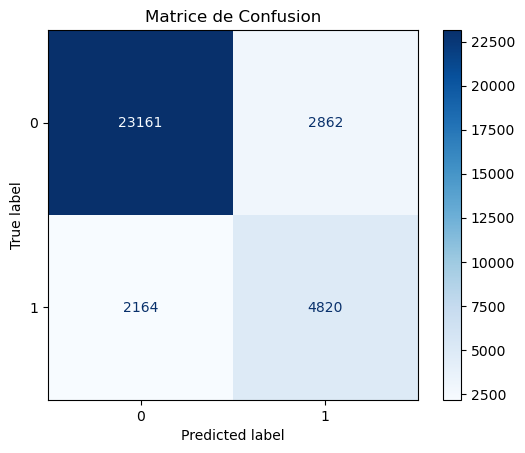

In [16]:
# Visualisation 2 : Matrice de Confusion
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Matrice de Confusion")
plt.show()


## La matrice compare les étiquettes réelles (True label) aux prédictions du modèle (Predicted label).

Vrais Négatifs (TN) : 23 161

Le modèle a prédit "0" et c'était effectivement "0". C'est votre plus grande réussite.

Vrais Positifs (TP) : 4 820

Le modèle a prédit "1" et c'était effectivement "1".

Faux Positifs (FP) : 2 862 (Erreur de Type I)

Le modèle a prédit "1" mais c'était en réalité "0". C'est une "fausse alerte".

Faux Négatifs (FN) : 2 164 (Erreur de Type II)

Le modèle a prédit "0" mais c'était en réalité "1". C'est un "manqué".

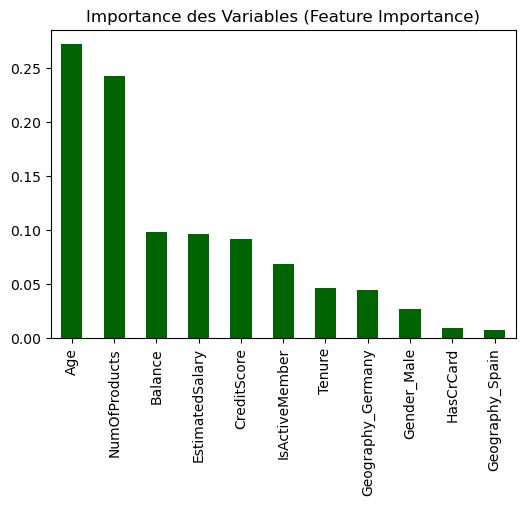

In [25]:
# Visualisation 3 : Importance des Variables
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6, 4))
importances.plot(kind='bar', color='darkgreen')
plt.title("Importance des Variables (Feature Importance)")
plt.show()


## Importance des variables

1. L'Âge (~27%) : C'est le prédicteur le plus puissant.
2. Le Nombre de Produits (~24%) : Le niveau d'équipement du client est crucial.
3. Le Solde (Balance) et le Salaire Estimé (~10% chacun) : Les facteurs financiers ont un impact modéré.
Les variables géographiques et la possession d'une carte de crédit ont une influence négligeable sur la décision du modèle


In [18]:
# 6. SAUVEGARDE FINALE

joblib.dump(best_model, 'modele_final_churn.pkl')
print("\nModèle sauvegardé : modele_final_churn.pkl")


Modèle sauvegardé : modele_final_churn.pkl
